# Pichu or Pikachu?

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import copy

################################################################################################ Preprocessing

def load_data(TRAIN_DATA, TEST_DATA):

    with open(TRAIN_DATA, "r") as file:
        TRAINING_ROWS = [row.strip("\n").split(", ") for row in file.readlines()[1:]]

    TRAINING_POINTS = []
    for training_row in TRAINING_ROWS:
        formated_training_rows = [int(value) if value.isdigit() else float(value) for value in training_row ]
        TRAINING_POINTS.append(formated_training_rows)


    TRAINING_WIDTH = [r[0] for r in TRAINING_POINTS]
    TRAINING_HEIGHT = [r[1] for r in TRAINING_POINTS]
    TRAINING_LABEL = [r[2] for r in TRAINING_POINTS]

    TRAINING_COLUMNS = {'Width':TRAINING_WIDTH, 'Height':TRAINING_HEIGHT, 'Label':TRAINING_LABEL}

    ##########################################


    with open(TEST_DATA, "r") as file:
        TEST_ROWS = [row[4:].strip("\n").split(", ") for row in file.readlines()[1:]]
        
    TEST_ROWS = [i[:1] + [i[1][:-1]] for i in TEST_ROWS]

    TEST_WIDTH = [float(v[0]) for v in TEST_ROWS]
    TEST_HEIGHT = [float(v[1]) for v in TEST_ROWS]


    TEST_POINTS = []
    for test_row in TEST_ROWS:
        formated_testing_rows = [ [float(value) for value in test_row ] ]
        TEST_POINTS.append(formated_testing_rows)

    return [TRAINING_COLUMNS, TRAINING_POINTS], [TEST_POINTS, TEST_WIDTH, TEST_HEIGHT]


In [28]:

def graph(TRAINING_COLUMNS):

    sns.relplot(data=TRAINING_COLUMNS, x='Width', y='Height', hue='Label', hue_order=[0,1])
    plt.show()

#https://stackoverflow.com/questions/14885895/color-a-scatter-plot-by-column-values

In [29]:

def calculate_distance(TRAINING_COLUMNS, TRAINING_POINTS, TEST_WIDTH, TEST_HEIGHT):

    DISTANCES = []
    for p1, p2 in zip(TEST_WIDTH, TEST_HEIGHT):

        distance_list = [ ( (p1-qx)**2  + (p2-qy)**2 )**(1/2) for qx, qy in zip(TRAINING_COLUMNS['Width'], TRAINING_COLUMNS['Height']) ]

        DISTANCES.append(distance_list)


    DISTANCES_COPY = copy.deepcopy(DISTANCES)
    CLOSEST_NEIGHBOUR = []

    for i in DISTANCES_COPY:
        i.sort()
        CLOSEST_NEIGHBOUR.append(i[:10])


    NEIGHBOURS = [] #index till 10 närmsta grannarna för alla 4 testdata rader 
    for idx, l in enumerate(CLOSEST_NEIGHBOUR):
        
        neighbours_list = [DISTANCES[idx].index(v) for v in l ]
        
        NEIGHBOURS.append(neighbours_list)


    NEIGHBOURS_IDX = []
    for nl in NEIGHBOURS:
        neighbours_idx_list = [TRAINING_POINTS[n] for n in nl] 
        NEIGHBOURS_IDX.append(neighbours_idx_list)

    return NEIGHBOURS_IDX


In [30]:
def classifying(NEIGHBOURS_IDX, TEST_POINTS):

    pikachu_amount = 0
    pichu_amount = 0
    for idx, i in enumerate(NEIGHBOURS_IDX):
        neighbour_pikachu = 0
        for ii in i:
            neighbour_pikachu += ii.count(1)

        if neighbour_pikachu >= 5:
            print(f"Sample with (width, height) ({str(TEST_POINTS[idx][0])[1:-1]}) classified as Pikachu")
            pikachu_amount += 1
        else:
            print(f"Sample with (width, height) ({str(TEST_POINTS[idx][0])[1:-1]}) classified as Pichu")
            pichu_amount += 1
    
    print(f'Amount of Pikachus: {pikachu_amount}, Pichus: {pichu_amount}')
    

In [31]:

def add_test_points():

    width = input("Enter width: ")
    height = input("Enter height: ")

    with open("testpoints.txt") as file:
        nr_of_rows = len(file.readlines())


    new_test_points = f"{nr_of_rows}. ({width}, {height})" + '\n'

    with open("testpoints.txt", "a") as file:
        file.write(new_test_points)



###Pichu or Pikachu?###
[1] Plot datapoints
[2] Pichu or Pickahu?
[3] Add datapoints
What would you like to do?
Sample with (width, height) (25.0, 32.0) classified as Pikachu
Sample with (width, height) (24.2, 31.5) classified as Pikachu
Sample with (width, height) (22.0, 34.0) classified as Pikachu
Sample with (width, height) (20.5, 34.0) classified as Pichu
Amount of Pikachus: 3, Pichus: 1


C:\Users\hemli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\hemli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\hemli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

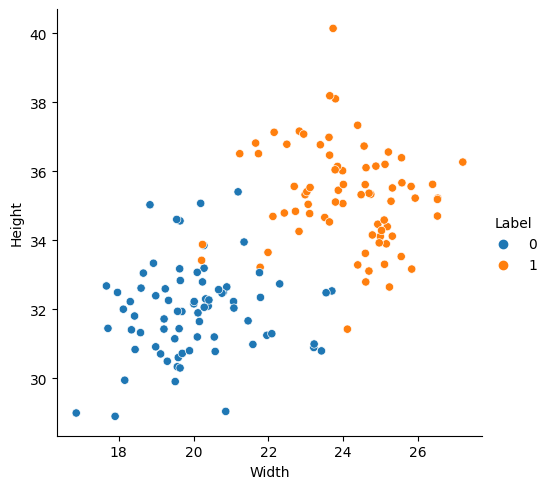

In [32]:


print("###Pichu or Pikachu?###")
print("[1] Plot datapoints")
print("[2] Pichu or Pickahu?")
print("[3] Add datapoints")
print("What would you like to do?")





TRAIN_DATA, TEST_DATA = load_data("datapoints.txt", "testpoints.txt")


while True:
    choice = input("Pick number from 1-3")
    if not choice.isdigit():
        break
    if int(choice) == 1:
        graph(TRAIN_DATA[0])
    elif int(choice) == 2:
        
        NEIGHBOURS_IDX = calculate_distance(TRAIN_DATA[0], TRAIN_DATA[1], TEST_DATA[1], TEST_DATA[2])
        classifying(NEIGHBOURS_IDX, TEST_DATA[0])

    elif int(choice) == 3:
        add_test_points()
    




In [32]:
import random

with open("datapoints.txt", "r") as file:
    DATAROWS = [row.strip("\n").split(", ") for row in file.readlines()[1:]]

DATAPOINTS = []
for drow in DATAROWS:
    formated_rows = [int(values) if values.isdigit() else float(values) for values in drow ]
    DATAPOINTS.append(formated_rows)

random.shuffle(DATAPOINTS)

test_set = []
train_set = []

pik = 0
pich = 0

for i in DATAPOINTS:
    if i[-1] == 1 and pik < 25:
        pik +=1
        test_set.append(i)
    elif i[-1] == 0 and pich < 25:
        pich += 1
        test_set.append(i)
    else:
        train_set.append(i)


with open("shuffledpoints.txt", "w") as file:
    for i in train_set:
        file.write(f"{i[0]}, {i[1]}, {i[2]}" + '\n')

with open("shuffled_test_points.txt", "w") as file:
    for i in test_set:
        file.write(f"{i[0]}, {i[1]}, {i[2]}" + '\n')

